In [1]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [2]:
import gseapy as gp
from gseapy.plot import dotplot
from reactome2py import analysis
def gene_enrich(genelist, type, sets=None, save=False):
    p_value = 0.05
    if type not in ["GO", "KEGG", "REACTOME", "WIKIPATHWAY"]:
        print("Type is not valid! it should be one of them GO, KEGG, REACTOME, WIKIPATHWAY")
    else:
        if type == "GO" and sets is None:
            sets = ["GO_Biological_Process_2021", "GO_Cellular_Component_2021", "GO_Molecular_Function_2021"]
        elif type == "KEGG" and sets is None:
            sets = ["KEGG_2019_Human"]
        elif type == "REACTOME" and sets is None:
            sets = ["Reactome_2016"]
        elif type == "WIKIPATHWAY" and sets is None:
            sets = ["WikiPathways_2019_Human"]
           
        if type in ["GO", "KEGG", "REACTOME", "WIKIPATHWAY"]:
            try:
                enr = gp.enrichr(gene_list=genelist,
                                gene_sets=sets,
                                organism='human',
                                #outdir=r"D:\study\thesis\project\HBDM-main\ppi_results\gene_enrichment",
                                cutoff=p_value)
                ax = dotplot(enr.res2d,
                            title=f"Gene ontology in {type} module",
                            cmap='viridis_r',
                            cutoff=p_value)
                ax.show()
            except:
                print(f"No enrich terms when cutoff = {p_value} in module {type}")
        else:
                numGeneModule = len(geneModule)
                geneModule = ",".join(geneModule)
                p_value = 0.05
                result = analysis.identifiers(ids=geneModule,
                                                species='Homo sapiens',
                                                p_value=str(p_value))
                token = result['summary']['token']
                if save == True:
                        analysis.report(token,
                                        path="/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/results/gene_enrich",
                                        file="report.pdf",
                                        number='50',
                                        species='Homo sapiens')
                token_result = analysis.token(token,
                        species='Homo sapiens',
                        p_value=str(p_value))
 
                print(
                f"{numGeneModule - token_result['identifiersNotFound']} out of {numGeneModule} genes (identifiers) in the sample were found in Reactome.")
                print(
                f"{token_result['resourceSummary'][0]['pathways']} pathways were hit by at least one of them, which {len(token_result['pathways'])} of them have p-value less than {p_value}.")
                print(f"For more information please visit https://reactome.org/PathwayBrowser/#/DTAB=AN&ANALYSIS={token}")

In [3]:
name = 'Dataset-ppi--RE-True--W-1--Epochs-4000--D-2--RH-25--LR-0.1--LP-False--CUDA-True'
root = 'D:/study/thesis/project/HBDM-main/ppi_results/models/'+name
# dataset = 'ppi_g'

### get node and 1d,2d
file_path_d = root+'/latent.pkl'
with open(file_path_d, 'rb') as file:
    node_rep = pickle.load(file)

# tensor = loaded_tensor.cpu()
# node_rep = tensor.detach().numpy()

node_rep = np.array(node_rep)
df_latent = pd.DataFrame()
for d in range(node_rep.shape[1]):
    col_name = str(d+1)+'d'
    df_latent[col_name] = node_rep.T[d]
df_latent['node'] = df_latent.index

df = df_latent
df.head(3)

,1d,2d,node
0,-2.246186,0.058630,0
1,-2.289171,1.525963,1
2,0.972802,-0.694865,2


In [4]:
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_name2stringId.pkl', 'rb') as file:
    name2stringId = pickle.load(file)
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_index.pkl', 'rb') as file:
    ppi_index = pickle.load(file)
node2string = {value: key for key, value in ppi_index.items()}
string2name = {value: key for key, value in name2stringId.items()}

In [4]:
df['gene'] = df['node'].map(node2string).map(string2name)

In [5]:
subdf = df[['1d', '2d', '3d', '4d']]
linkage_matrix = linkage(subdf, method='ward')

In [14]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [12]:
X = subdf.values

# Specify the number of clusters (k)
k = 10

# Perform k-means clustering with k-means++ initialization
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
df['Cluster_k'] = kmeans.fit_predict(X)

c:\Users\ZZY\.conda\envs\rescal\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


C:\Users\ZZY\AppData\Local\Temp\ipykernel_25720\1681430292.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


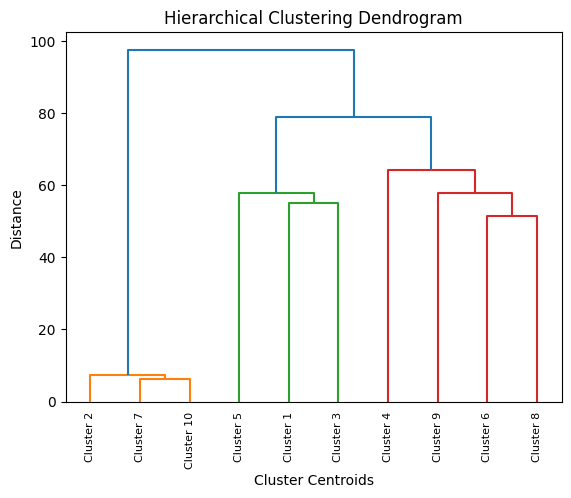

In [15]:
centroids = kmeans.cluster_centers_
distance_matrix = cdist(centroids, centroids, metric='euclidean')
# Perform hierarchical clustering using the distance matrix
linkage_matrix = linkage(distance_matrix, method='ward')

# Plot the dendrogram
dendrogram(linkage_matrix, labels=[f'Cluster {i+1}' for i in range(k)], orientation='top', leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Centroids')
plt.ylabel('Distance')
plt.show()

In [17]:
df['Cluster_kh'] = df['Cluster_k']
df.loc[df['Cluster_kh'].isin([2, 7, 20]), 'Cluster_kh'] = 3

In [18]:
df['Cluster_kh'].value_counts()

9    8493
6    5213
1    4336
3     314
5     136
4      96
0      94
8      85
Name: Cluster_kh, dtype: int64

No enrich terms when cutoff = 0.05 in module GO


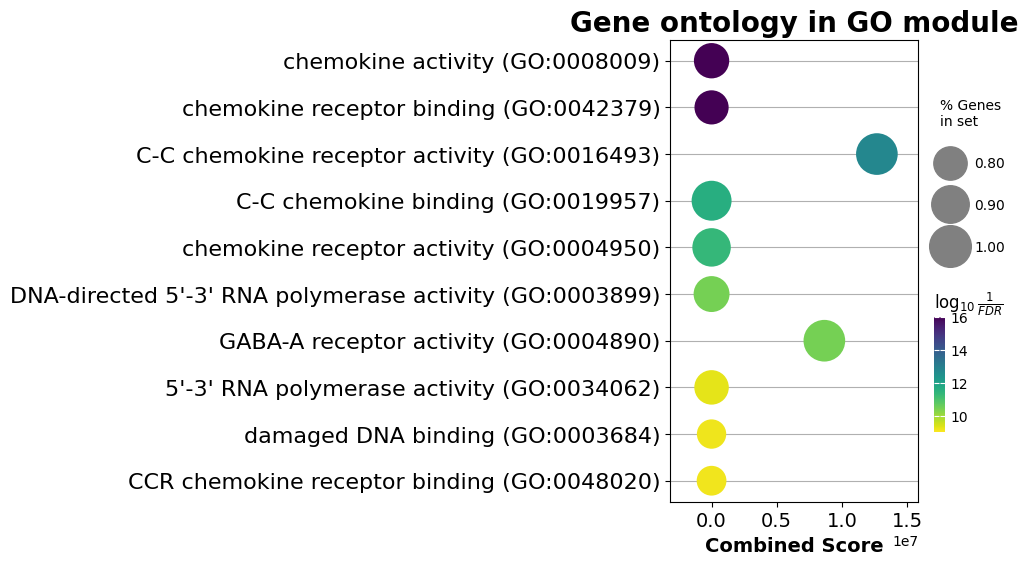

In [27]:
gene_enrich(df[df['Cluster_kh']==1]['gene'].to_list(),'GO')

No enrich terms when cutoff = 0.05 in module GO


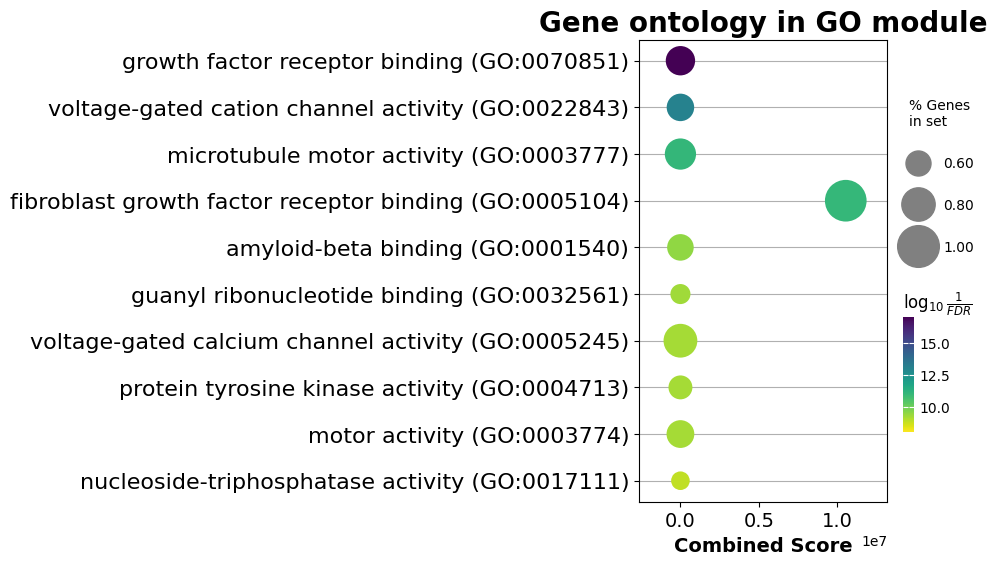

In [26]:
gene_enrich(df[df['Cluster_kh']==6]['gene'].to_list(),'GO')

No enrich terms when cutoff = 0.05 in module GO


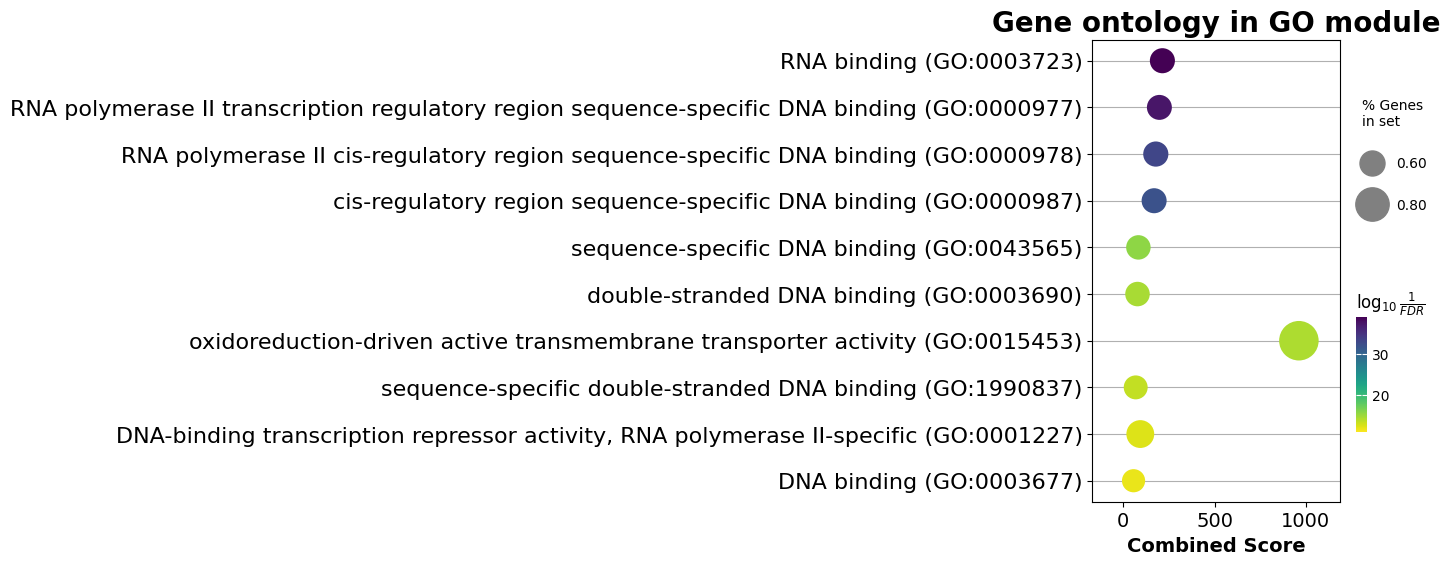

In [25]:
gene_enrich(df[df['Cluster_kh']==9]['gene'].to_list(),'GO')

In [31]:
import scipy.cluster.hierarchy as sch
import os
def overview(dataset):
    name = 'Dataset-'+dataset+'--RE-True--W-1--Epochs-15000--D-4--RH-25--LR-0.1--LP-False--CUDA-True'
    root = 'D:/study/thesis/project/HBDM-main/ppi_results/models/'+name
    variable_names = ['k_exp_dist', 'general_cl_id', 'general_mask']
    # Initialize a dictionary to store the loaded variables
    loaded_variables = {}
 
    # Loop through the variable names and load the data from pickle files
    for var_name in variable_names:
        file_path = os.path.join(root, var_name + '.pkl')
        with open(file_path, 'rb') as f:
            loaded_data = pickle.load(f)
        loaded_variables[var_name] = loaded_data
 
    # Access the loaded variables as needed
    k_exp_dist = loaded_variables['k_exp_dist']
    # final_idx = loaded_variables['final_idx']
    general_cl_id = loaded_variables['general_cl_id']
    general_mask = loaded_variables['general_mask']
 
    k_exp_dist = np.array(k_exp_dist)
    level_list = []
    # check the cluster ids in different levels
    for level, i in enumerate(general_cl_id):
        a = list(set(i))
        level_list.append(a)
        print(len(list(set(i))),' cluster num in level ',level+1)
    # Create your matrix of within-cluster Euclidean distances
    distance_matrix = k_exp_dist[:10,:10]
    # Perform hierarchical clustering
    linkage_matrix = sch.linkage(distance_matrix, method='average')
    dendrogram = sch.dendrogram(linkage_matrix, color_threshold=0)
    return general_cl_id, general_mask, level_list
 
def hierachical_structure(dataset,general_cl_id, general_mask, level_list):
    index_dict = dict()
    for i, l in enumerate(general_cl_id):
        for j, cluster in enumerate(l):
            if cluster in index_dict:
                index_dict[cluster].append(general_mask[i][j])
            else:
                index_dict[cluster] = [general_mask[i][j]]
    level_dict = dict()
    for i in range(len(level_list)):
        if i == len(level_list)-1:
            l = level_list[i]
            for c1 in l:
                level_dict[c1] = []
        else:
            l = level_list[i]
            subl = level_list[i+1]
            # print(l,subl)
            for c1 in l:
                # print(c1)
                for c2 in subl:
                    # print(c2)
                    if set(index_dict[c1]) & set(index_dict[c2]):
                        # print(c2 ,'in',c1)
                        if c1 in level_dict:
                            level_dict[c1].append(c2)
                        else:
                            level_dict[c1] = [c2]
                if c1 not in level_dict:
                    level_dict[c1] = []
 
    ## get node and cluster
    df = pd.DataFrame({'node':range(max(list(set(general_mask[0])))+1)})
    for i, level in enumerate(general_cl_id):
        clusters = list(set(level))
        col = []
        ori_index = []
        colname = 'level_'+str(i+1)
        for key in clusters:
            col += len(index_dict[key])*[int(key)]
            ori_index.extend(index_dict[key])
        dftemp = pd.DataFrame({'node': ori_index, colname: col})
        df = df.merge(dftemp,how='left')
    convertpath = 'D:/study/thesis/project/HBDM-main/data/datasets/'+dataset+'/ppi_index.pkl'
    with open(convertpath, 'rb') as file:
        ppi_index = pickle.load(file)
    inv_dict = {v: k for k, v in ppi_index.items()}
    df['gene'] = df['node'].map(inv_dict)
    return df

10  cluster num in level  1
20  cluster num in level  2
40  cluster num in level  3
80  cluster num in level  4
156  cluster num in level  5
264  cluster num in level  6
416  cluster num in level  7
498  cluster num in level  8
358  cluster num in level  9
188  cluster num in level  10
62  cluster num in level  11
14  cluster num in level  12
4  cluster num in level  13


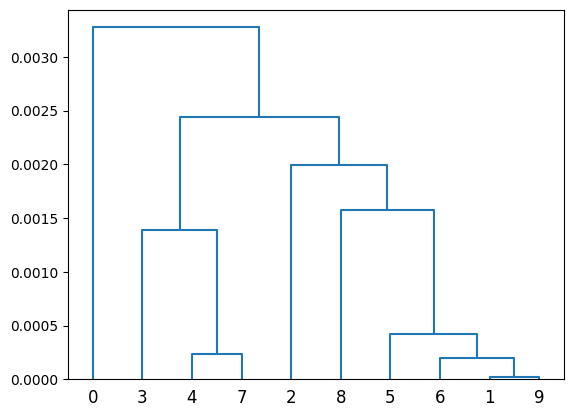

In [32]:
general_cl_id, general_mask, level_list = overview('ppi')
ppi_10_df = hierachical_structure('ppi',general_cl_id, general_mask, level_list)

In [33]:
ppi_10_df['level_1'].value_counts()

2    3154
0    2763
4    2251
8    2165
6    1802
7    1739
3    1706
5    1594
9    1114
1     479
Name: level_1, dtype: int64

In [36]:
ppi_10_df['gene'] = ppi_10_df['node'].map(node2string).map(string2name)

In [39]:
len(ppi_10_df[ppi_10_df['level_1'].isin([5,6,1,9])])

4989

No enrich terms when cutoff = 0.05 in module GO


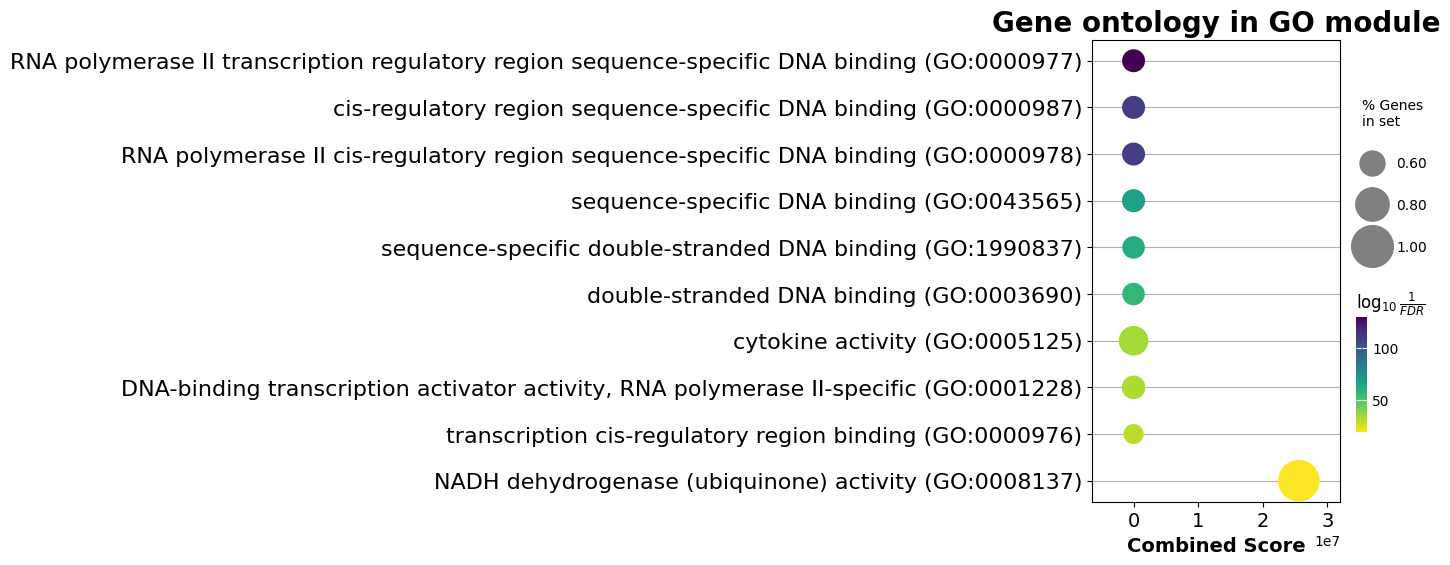

In [38]:
gene_enrich(ppi_10_df[ppi_10_df['level_1'].isin([5,6,1,9])]['gene'].to_list(),'GO')

No enrich terms when cutoff = 0.05 in module GO


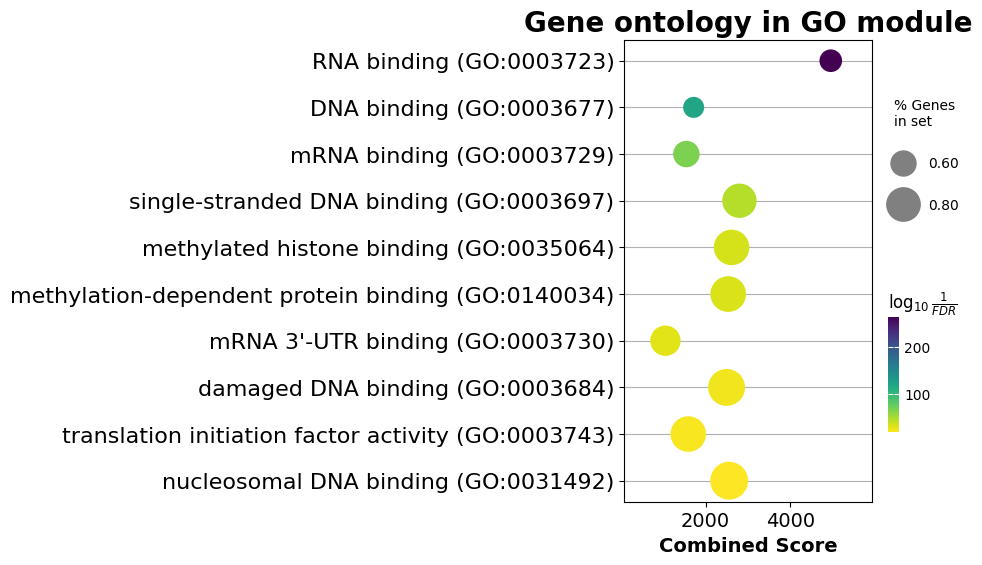

In [37]:
gene_enrich(ppi_10_df[ppi_10_df['level_1']==2]['gene'].to_list(),'GO')

No enrich terms when cutoff = 0.05 in module GO
No enrich terms when cutoff = 0.05 in module GO
No enrich terms when cutoff = 0.05 in module GO
No enrich terms when cutoff = 0.05 in module GO
No enrich terms when cutoff = 0.05 in module GO


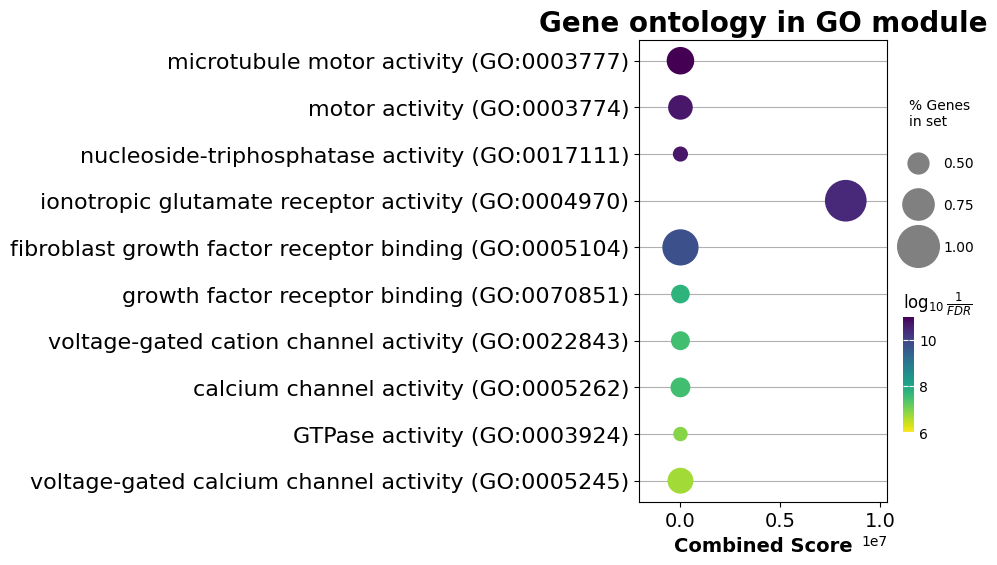

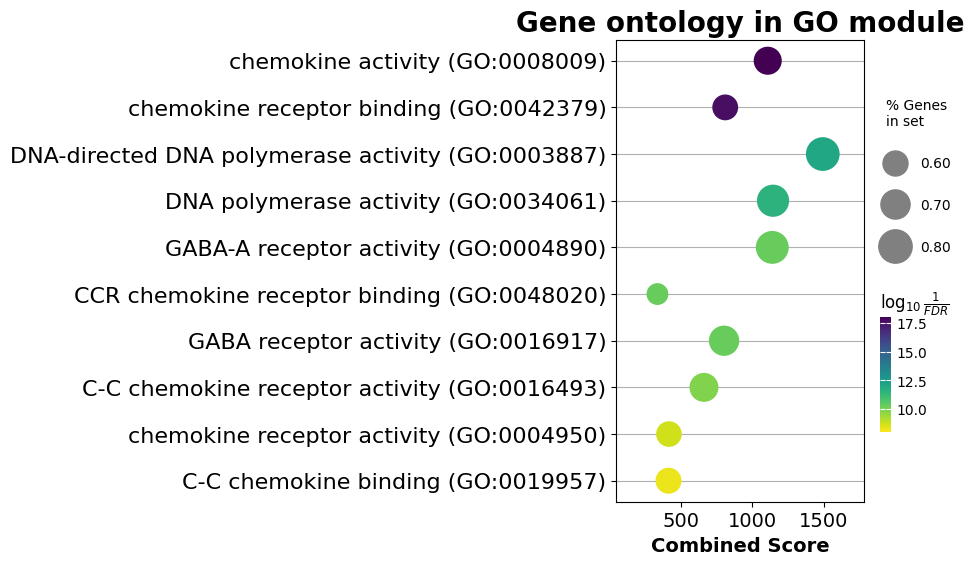

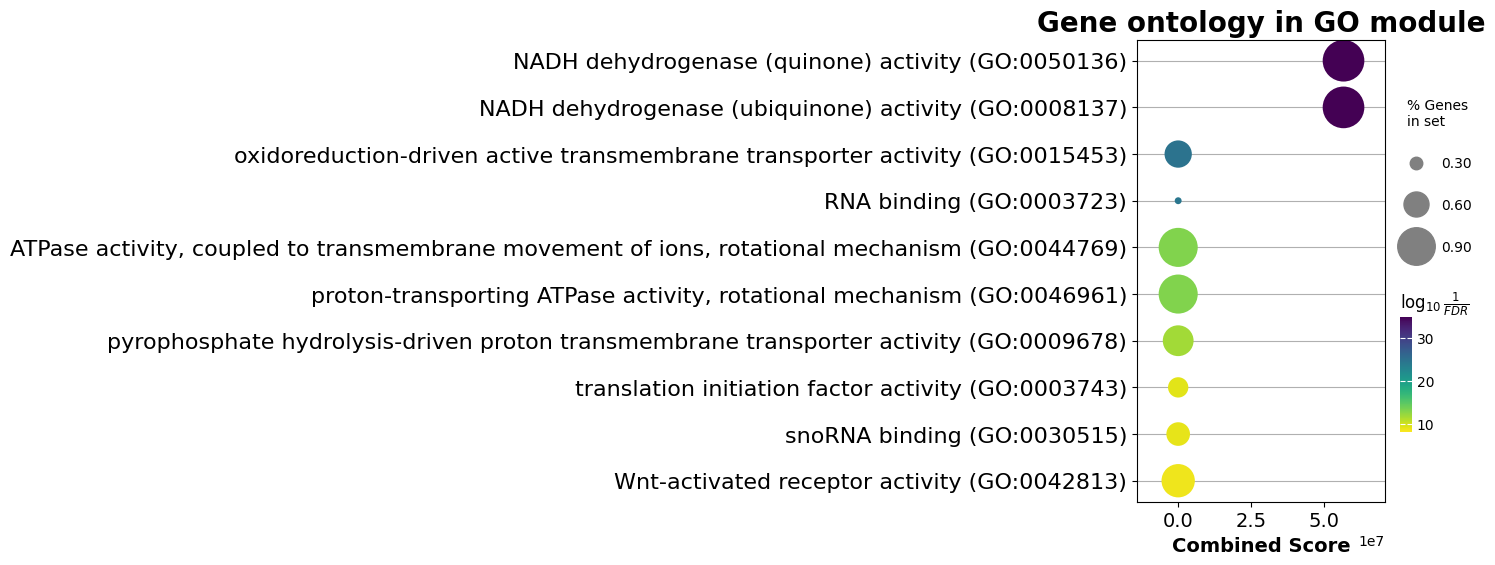

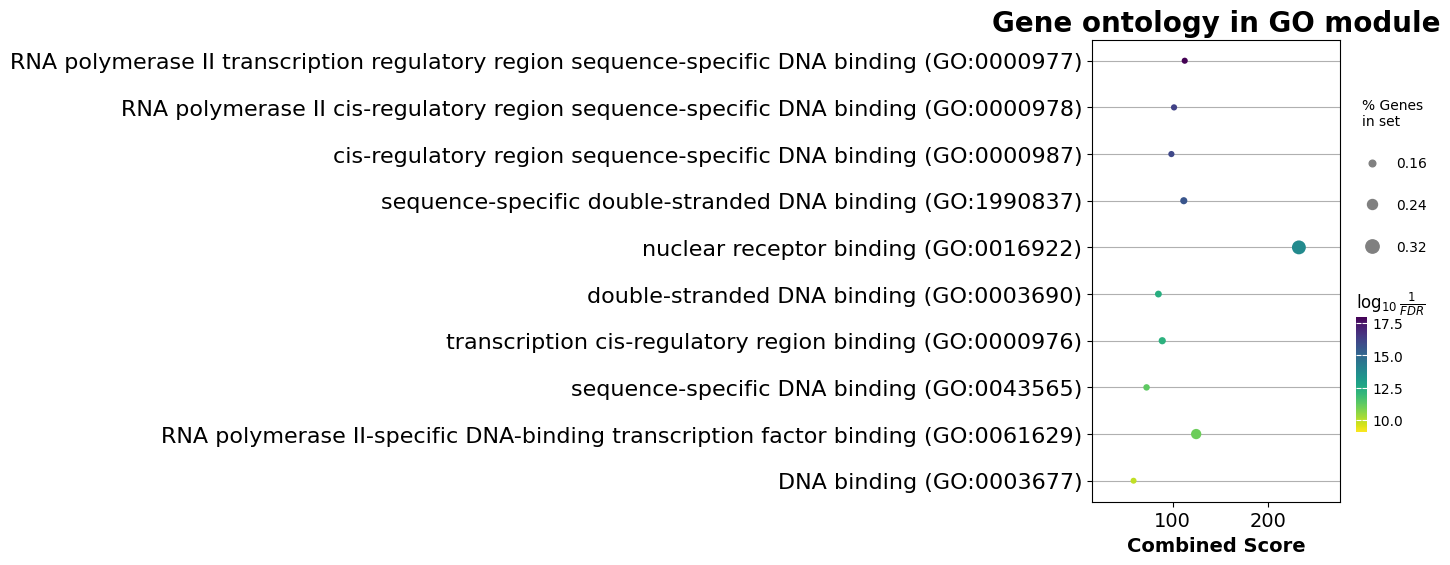

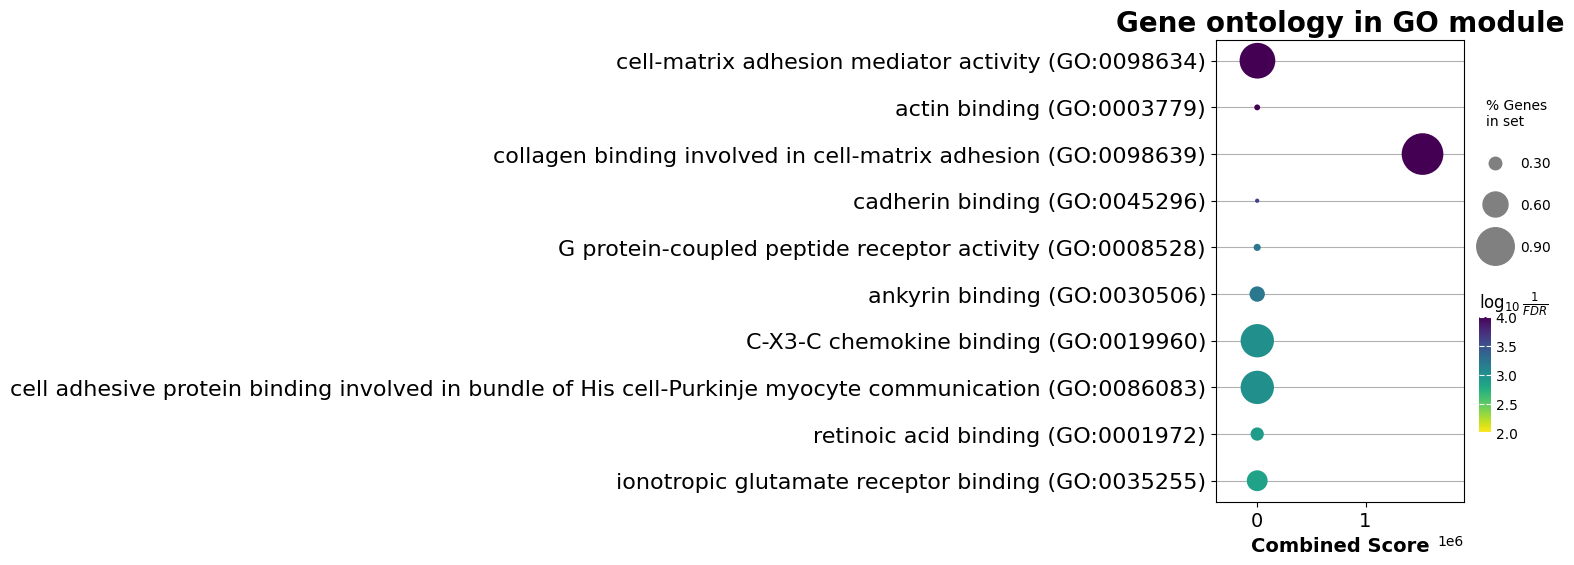

In [39]:
for i in [21,18,17,16,20]:
    gene_enrich(df[df['Cluster']==i]['gene'].to_list(),'GO')

No enrich terms when cutoff = 0.05 in module GO


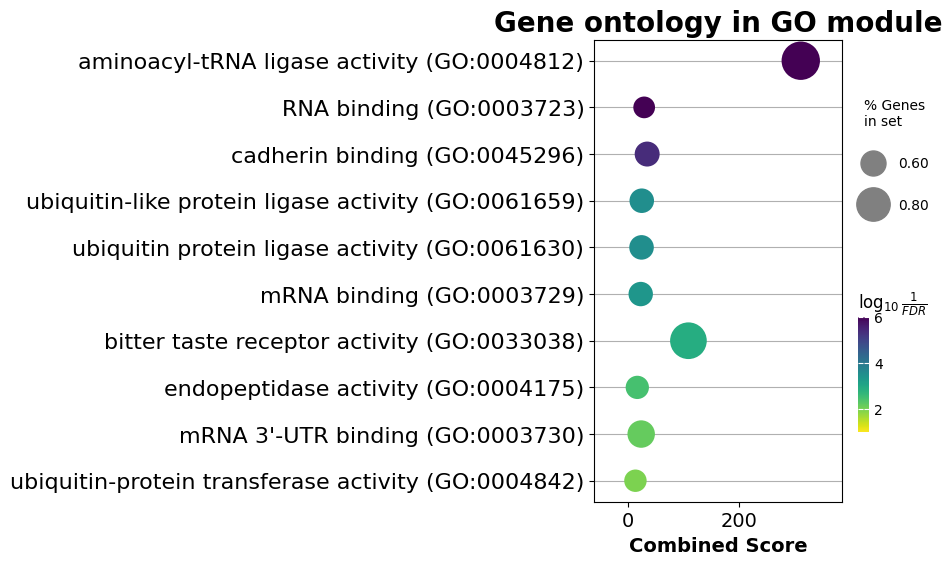

In [38]:
gene_enrich(df[df['Cluster']==19]['gene'].to_list(),'GO')

No enrich terms when cutoff = 0.05 in module GO


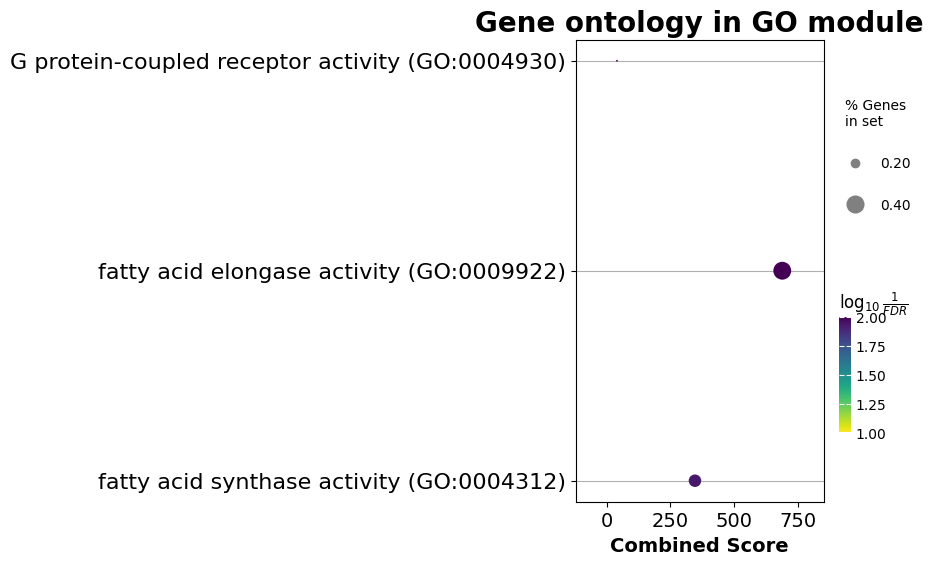

In [31]:
gene_enrich(df[df['Cluster']==2]['gene'].to_list(),'GO')

No enrich terms when cutoff = 0.05 in module GO


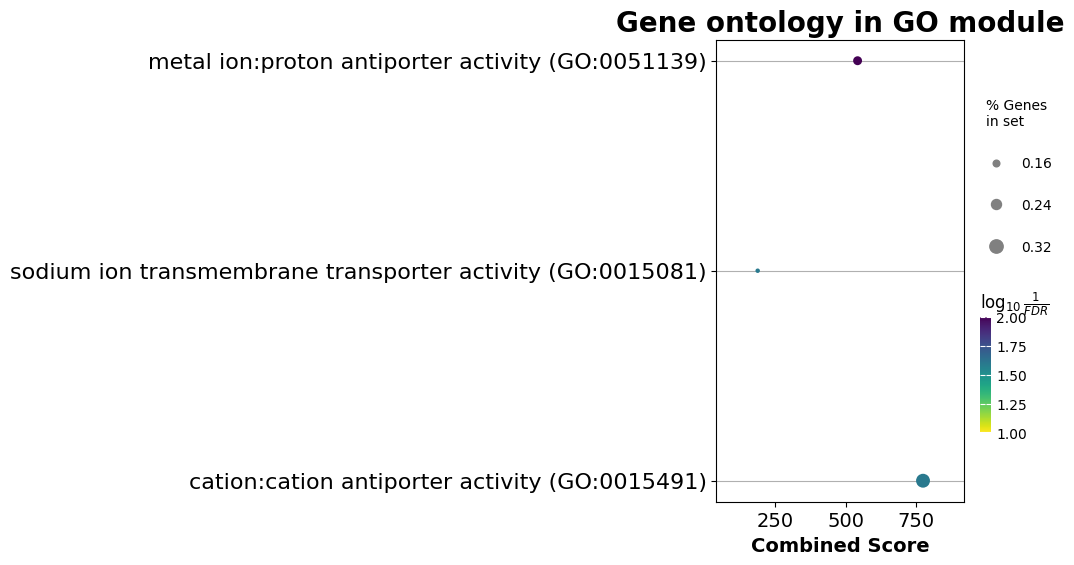

In [30]:
gene_enrich(df[df['Cluster']==1]['gene'].to_list(),'GO')